In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import biosppy
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization
from keras.utils import np_utils

In [2]:
# %%
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
    

sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["A", "N", "R", "V"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 80

keras version  2.8.0



--- Load, inspect and transform data ---



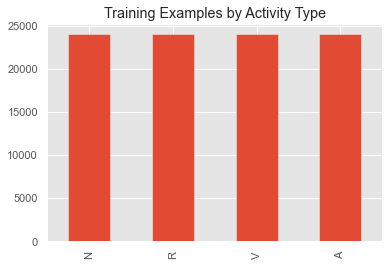

In [3]:

def show_basic_dataframe_info(dataframe,
                              preview_rows=20):
    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())

def read_data(file_path):
    df = pd.read_csv(file_path, float_precision='round_trip')
    return df
    
# %%

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('../db_80_sehat.csv')
df_val = read_data('../db_80_val_sampel.csv')
df_test = read_data('../db_80_test_sampel.csv')
# Describe the data
# show_basic_dataframe_info(df, 20)

# df['label'].value_counts().plot(kind='bar',
#                                    title='Training Examples by Activity Type')

# df_val['label'].value_counts().plot(kind='bar',
#                                    title='Training Examples by Activity Type')

df_test['label'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')

plt.show()

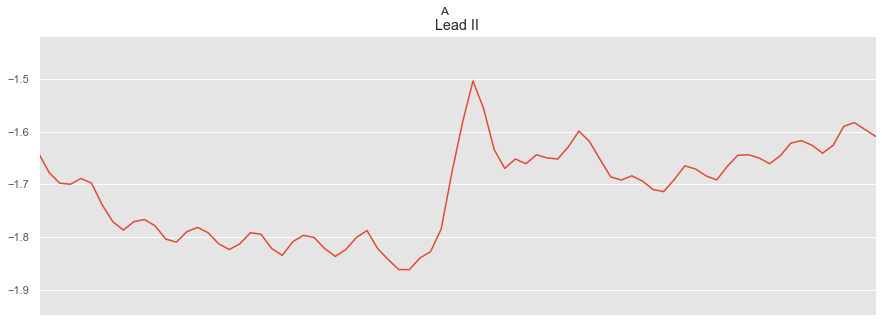

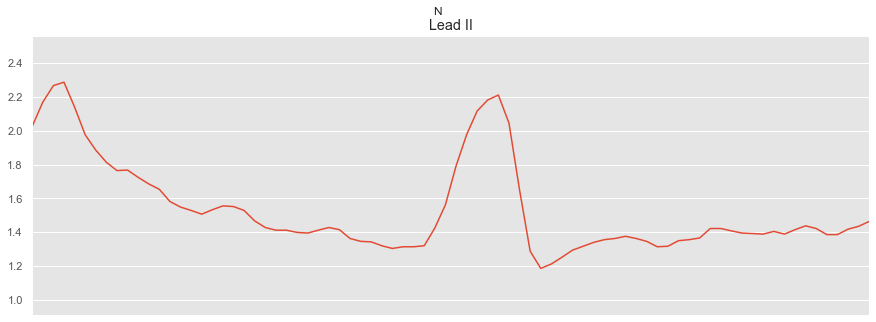

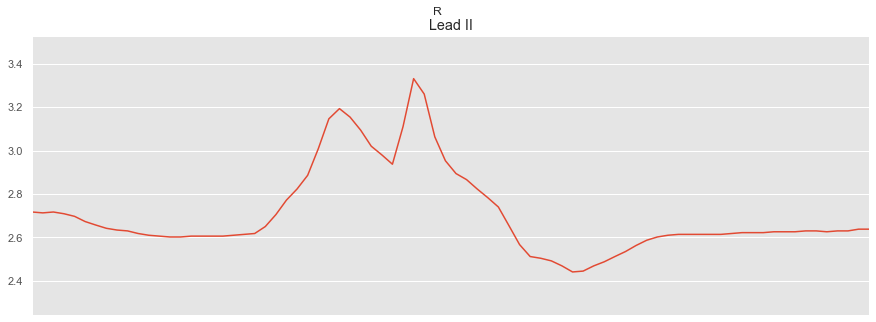

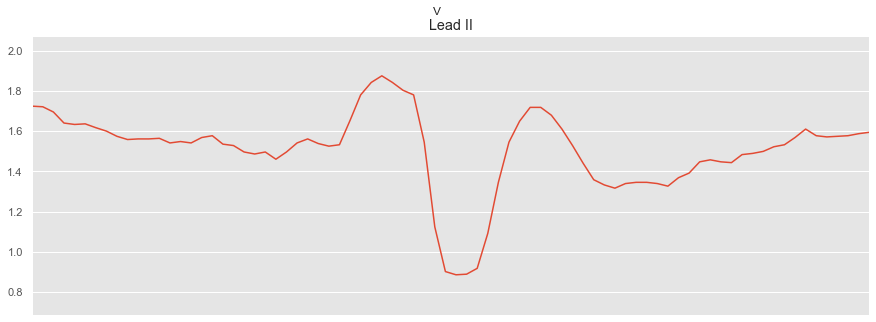

In [4]:
def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0) = plt.subplots(nrows=1, figsize=(15, 5), sharex=True)
    plot_axis(ax0, data['time'], data['II'], 'Lead II')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
for activity in np.unique(df["label"]):
    subset = df[df["label"] == activity][0:80]
    plot_activity(activity, subset)

In [5]:
def feature_normalize(dataset):

    # mu = np.mean(dataset, axis=0)
    # sigma = np.std(dataset, axis=0)
    # return (dataset - mu)/sigma
    _, Filtered, Rpeak, _, _, _, _ = biosppy.signals.ecg.ecg(
    signal=dataset, sampling_rate=257.0, show=False)
    print(Filtered)
    return Filtered
    
def create_segments_and_labels(df, time_steps, step, label_name):

    N_FEATURES = 1
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    
    for i in range(0, len(df), step):
        xs = df['II'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# %%


# Define column name of the label vector
LABEL = "ActivityEncoded"

# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()

# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["label"].values.ravel())
df_val[LABEL] = le.fit_transform(df_val["label"].values.ravel())
df_test[LABEL] = le.fit_transform(df_test["label"].values.ravel())

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_train = df[df['id'] > 0]

# Normalize features for training data set
df_train['II'] = feature_normalize(df['II'])
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'II': 6})

print(df_train)

df_val['II'] = feature_normalize(df_val['II'])
df_val = df_val.round({'II': 6})

print(df_val)

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE, LABEL)
x_val, y_val = create_segments_and_labels(df_val, TIME_PERIODS, STEP_DISTANCE, LABEL)

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print(x_train)

print('x_val shape: ', x_val.shape)
print(x_val.shape[0], 'validation samples')
print(x_val)

# Inspect y data
print('y_val shape: ', y_val.shape)
print(y_val)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))


--- Reshape the data into segments ---

[0.09191439 0.28031929 0.39596656 ... 0.03295057 0.02299351 0.01181941]
        id label                time         I        II       III       AVR  \
0        1     N          '0:00.284'  3.657000  0.091914  0.366000 -2.977000   
1        1     N          '0:00.288'  3.712000  0.280319  0.454000 -3.075000   
2        1     N          '0:00.292'  3.758000  0.395967  0.507000 -3.147000   
3        1     N          '0:00.296'  3.739000  0.404067  0.546000 -3.147000   
4        1     N          '0:00.300'  3.663000  0.322248  0.474000 -3.036000   
...     ..   ...                 ...       ...       ...       ...       ...   
771995  50     N  1656226030.4532816  0.012500  0.037888 -0.020732 -0.091776   
771996  50     N  1656226030.4532816  0.012500  0.039016 -0.014634 -0.089145   
771997  50     N  1656226030.4632845  0.008333  0.032951 -0.014634 -0.087061   
771998  50     N  1656226030.4632845  0.008333  0.022994 -0.014634 -0.087061   
771999 

In [6]:
# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_val = x_val.reshape(x_val.shape[0], input_shape)

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

x_val = x_val.astype("float32")
y_val = y_val.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

y_val = np_utils.to_categorical(y_val, num_classes)
print('New y_val shape: ', y_val.shape)

print(x_train)
print(y_train)
print(x_val)
print(y_val)

x_train shape: (9650, 80)
x_val shape: (1200, 80)
input_shape: 80
New y_train shape:  (9650, 4)
New y_val shape:  (1200, 4)
[[ 9.19140e-02  2.80319e-01  3.95967e-01 ...  1.52000e-04  2.38150e-02
   6.40860e-02]
 [ 1.11712e-01  1.54317e-01  1.81520e-01 ...  5.21600e-02  5.29390e-02
   5.20960e-02]
 [ 5.20120e-02  5.55430e-02  6.25870e-02 ... -1.65820e-02 -1.69700e-03
   4.29570e-02]
 ...
 [-8.10000e-03 -2.16510e-02 -1.56050e-02 ...  6.92970e-02  4.88570e-02
   1.94040e-02]
 [-6.44700e-03 -1.75220e-02 -1.02730e-02 ...  6.08030e-02  4.04580e-02
   1.26700e-02]
 [-1.29510e-02 -2.63500e-02 -2.23700e-02 ...  3.29510e-02  2.29940e-02
   1.18190e-02]]
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[[ 0.040785  0.070626  0.09806  ... -0.076053 -0.083114 -0.028129]
 [ 0.073904  0.179934  0.247079 ... -0.002917 -0.00914  -0.001767]
 [ 0.010738  0.019919  0.026194 ... -0.099702 -0.090971 -0.035607]
 ...
 [ 0.221408  0.423217  0.512301 ... -0.19022  

In [7]:
# %%

print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(BatchNormalization())
model_m.add(Conv1D(80, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(80, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

# %%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(x_val, y_val),
                      verbose=1)

# %%


--- Create neural network model ---

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 80, 1)             0         
                                                                 
 batch_normalization (BatchN  (None, 80, 1)            4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 71, 80)            880       
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 80)            64080     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 80)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)


--- Learning curve of model training ---



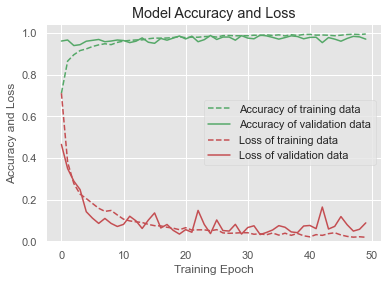

In [8]:
model_m.save("modelII.h5")
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#%%


--- Check against test data ---

[ 0.01347412  0.00235795 -0.00344967 ... -0.09552434 -0.08242232
 -0.06564665]
38/38 [==============================] - 1s 17ms/step - loss: 0.4388 - accuracy: 0.8983

Accuracy on test data: 0.90

Loss on test data: 0.44

--- Confusion matrix for test data ---



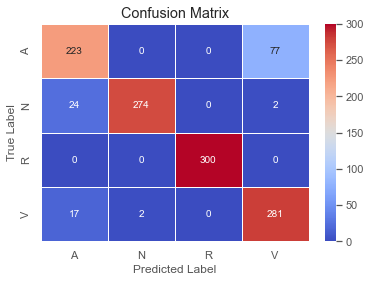


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       300
           1       0.99      0.91      0.95       300
           2       1.00      1.00      1.00       300
           3       0.78      0.94      0.85       300

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [9]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['II'] = feature_normalize(df_test['II'])

df_test = df_test.round({'II': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

np.set_printoptions(threshold=sys.maxsize)
# print(x_test)
print(max_y_test)
# print(y_test)
print(max_y_pred_test)